# Running this notebook
`bazel build Cartography:jupyter && ./bazel-bin/Cartography/jupyter`

# Contextual Building Typification in Automated Map Generalization
## Definitions
Cartographic generalization is an abstraction process that seeks to reduce the quantity of information in accordance with particular objectives. Here we care about scale, which means that the objective is to increase legibility. 

When generalizing buildings it is important to maintain:
1. Legibility
2. The visual identiy of each building
3. The pattern among a local group of buildings
4. The overal density of buildings across a region of the map.

## Legibility constraints
They ensure that the map will be readable. Legibility depends on size, contrast, brightness, etc. Legibility constraints can be divided into three classes:
1. *Perception* specifies  constraints on the sizes of objects or on their details. For instance: minimum size of a building or minimum edge size.
2. *Separation* specifies the minimum distance between two features.
3. *Maximum density* specifies the number of objects per unit area, and affects local readability.

These constraints can conflict with one another: for instance increasing the distance between objects and maintaining the density forces us to reduce their size. In order to help resolve theses conflicts, three criteria are defined:
1. *Visual identity* consists in making sure buildings can still be identified. 
    1. *The shape* should be respected. Buildings usually have orthogonal angles, which may need to be protected or restored after distortions.
    2. *The size* of a building gives important information about its type.
    3. *The color* also gives information about type.
2. *Spatial organization*, also called gestalt, can be specified with three constraints:
    1. *Proximity* is very important for identifying groups (= objects close together).
    2. *Similarity* allows us to group similar-looking objects, using for instance shape, size or orientation.
    3. *Continuity* is important for identifying objects having a linear disposition, for instance along a road.
3. *Homogeneity* must always be respected. For instance, we want to keep the fact that building density decreases as we move away from the city center.

## Methodology
Our goal is to derive a representation of buildings at a target scale, from a source map.
To do so by respecting the aforementioned constraints we can use the following approach:
1. Partition the source set of buildings into groups that are visually distinguishable.
2. Typify each group to create a representation suitable for the target scale. This involves enlarging buildings, eliminating some and give them a pattern reflecting the original distribution.
3. Assess the results with regard to the original constraints.


## Analysis and partitioning
The goal is to automatically identify groups of building that would correspond those found by visual inspection.

In a first instance, the road network and the rivers are used to partition the buildings.
Then the partitioning follows the following steps:
1. For a set of buildings belonging to the same partition, compute the proximity graph of these buildings.
2. From groups by segmenting successively the graph. The segmentation is based on homogeneity of the groups. Typification works better on groups with similar patterns, thus we need homogeneous groups.
3. We may need to reorganize the groups by merging small groups that are close together.

### Building a proximity graph
The primary criterion for grouping buildings is proximity.
Buildings are grouped using a minimum spanning tree, as:
- It links each building to its nearest neighbor, thus making the proximity explicit
- It stores chains of buildings, thus implicitely conveying the linear shape of the group
- It has no cycles, making it easy to segment or aggregate the graph

The MST is built by weighting the edges of the graph with the minimum distance between the two boundaries of the linked buildings.

To form the MST, an iterative process is used:
1. Link each building to its nearest neighbor
2. Link each group to its nearest neighbor, and so on.

### Constituing the groups
We follow an iterative process.
1. Analyse the regularity of the pattern of buildings for each group.
2. If the group is too irregular, segment it.
3. Repeat until the groups are homogeneous enough or too small.

The homogeneity of a group is determined according to two criteria:
- The size of buildings, as it can differentiate for instance residential and building areas
- The orientation of the buildings, as buildings are often oriented along bordering roads.

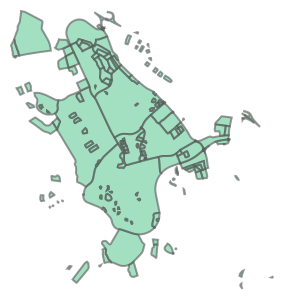

In [123]:
# Making the first groups by clustering buildings according to roads and rivers
# First step: define polygons set by boundaries of roads and rivers

# Open the road and rivers segments
import geopandas as gp
import pandas as pd
from shapely.geometry import box

roads = gp.read_file("Inputs/roads.gpkg")
rivers = gp.read_file("Inputs/rivers.gpkg")
joined = pd.concat([roads.geometry, rivers.geometry])
rect_bounds = box(*joined.total_bounds)
rect_bounds = gp.GeoDataFrame(index=[0], crs=joined.crs, geometry=[rect_bounds])

from shapely import polygonize
polygonize(joined.tolist())